In [19]:
# run this first
#!py -m pip install -q timm   # for EfficientNet variants (optional)
import os, glob, zipfile, shutil, json, random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
import timm
from tqdm.auto import tqdm   # ✔ Correct import
from sklearn.metrics import confusion_matrix, classification_report
print("PyTorch version:", torch.__version__)


PyTorch version: 2.5.1


In [5]:
import torch

print("torch version:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("device name:", torch.cuda.get_device_name(0))


torch version: 2.5.1
cuda available: True
device count: 1
device name: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [6]:
from pathlib import Path
import os

# This is the folder shown next to your notebook in Jupyter
dataset_dir = Path("Medicinal Leaf dataset")

print("Dataset path:", dataset_dir.resolve())
print("Exists:", dataset_dir.exists())

# Optional: quick tree view
for root, dirs, files in os.walk(dataset_dir):
    level = root.replace(str(dataset_dir), '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/ - {len(files)} files")
    for f in files[:5]:
        print(f"{indent}    {f}")
    if level >= 2:   # stop after depth 2
        break


Dataset path: C:\Users\ASUS\Desktop\DIP Project\Indian Medicinal Leaves Image Datasets\Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset
Exists: True
Medicinal Leaf dataset/ - 0 files
    Aloevera/ - 118 files
        10.jpg
        100.jpg
        102.jpg
        104.jpg
        106.jpg
    Amla/ - 67 files
        350.jpg
        352.jpg
        354.jpg
        356.jpg
        358.jpg
    Amruthaballi/ - 91 files
        484.jpg
        486.jpg
        488.jpg
        490.jpg
        492.jpg
    Arali/ - 89 files
        666.jpg
        668.jpg
        670.jpg
        672.jpg
        674.jpg
    ashoka/ - 81 files
        1000.jpg
        1002.jpg
        1004.jpg
        844.jpg
        846.jpg
    Astma_weed/ - 82 files
        1006.jpg
        1008.jpg
        1010.jpg
        1012.jpg
        1014.jpg
    Badipala/ - 76 files
        1170.jpg
        1172.jpg
        1174.jpg
        1176.jpg
        1178.jpg
    Balloon_Vine/ - 61 files
        1322.jpg
        1324.

In [7]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

import cv2
import numpy as np
from PIL import Image


Showing examples from:
 - C:\Users\ASUS\Desktop\DIP Project\Indian Medicinal Leaves Image Datasets\Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset\Pepper\IMG_20190707_083933.jpg
 - C:\Users\ASUS\Desktop\DIP Project\Indian Medicinal Leaves Image Datasets\Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset\Doddpathre\256.jpg
 - C:\Users\ASUS\Desktop\DIP Project\Indian Medicinal Leaves Image Datasets\Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset\Malabar_Spinach\64.jpg
 - C:\Users\ASUS\Desktop\DIP Project\Indian Medicinal Leaves Image Datasets\Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset\Tulsi\20190916_180938.jpg


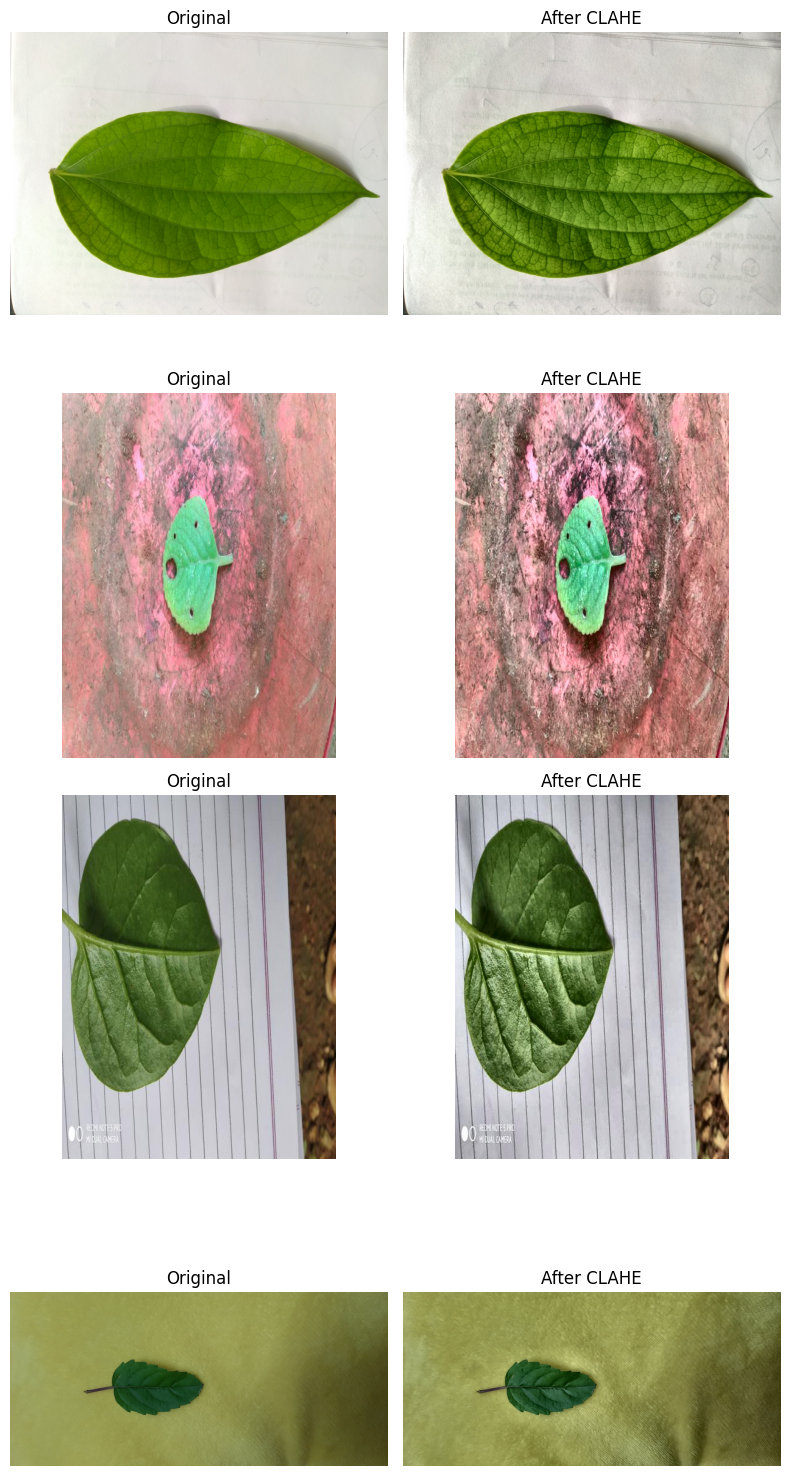

In [12]:
class CLAHEPreprocess(object):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(
            clipLimit=clip_limit,
            tileGridSize=tile_grid_size
        )

    def __call__(self, img):
        # img: PIL.Image (RGB)
        img_np = np.array(img)

        # RGB -> LAB
        lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
        L, A, B = cv2.split(lab)

        # CLAHE on L channel
        L_clahe = self.clahe.apply(L)

        # Merge and back to RGB
        lab_clahe = cv2.merge((L_clahe, A, B))
        rgb_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

        return Image.fromarray(rgb_clahe)

clahe = CLAHEPreprocess(clip_limit=2.0, tile_grid_size=(8, 8))

# 3. Pick 3–4 sample images from your dataset
#    Change this to your local dataset path
dataset_dir = r"C:\Users\ASUS\Desktop\DIP Project\Indian Medicinal Leaves Image Datasets\Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset"

# assume structure: dataset_dir/class_name/*.jpg
all_sample_paths = []
for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_dir):
        continue
    for fname in os.listdir(class_dir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            all_sample_paths.append(os.path.join(class_dir, fname))

# choose up to 4 random images
num_to_show = min(4, len(all_sample_paths))
sample_paths = random.sample(all_sample_paths, num_to_show)

print("Showing examples from:")
for p in sample_paths:f
    print(" -", p)

# 4. Plot before/after CLAHE
fig, axes = plt.subplots(num_to_show, 2, figsize=(8, 4 * num_to_show))

if num_to_show == 1:
    axes = np.array([axes])  # make it 2D for consistent indexing

for i, img_path in enumerate(sample_paths):
    original = Image.open(img_path).convert("RGB")
    processed = clahe(original)

    axes[i, 0].imshow(original)
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(processed)
    axes[i, 1].set_title("After CLAHE")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [9]:
# Adjust image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

clahe_tf = CLAHEPreprocess(clip_limit=2.0, tile_grid_size=(8, 8))

train_tfms = transforms.Compose([
    clahe_tf,                                  # CLAHE in LAB (L-channel)
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    clahe_tf,                                  # CLAHE, no data aug
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# dataset_dir should already point to your root folder:
# e.g. dataset_dir = r"C:\Users\...\Medicinal Leaf dataset"
full_dataset = datasets.ImageFolder(dataset_dir, transform=train_tfms)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Split
val_pct = 0.2
val_len = int(len(full_dataset) * val_pct)
train_len = len(full_dataset) - val_len

train_ds, val_ds = random_split(
    full_dataset,
    [train_len, val_len],
    generator=torch.Generator().manual_seed(SEED)
)

# Use validation transforms for the underlying dataset
val_ds.dataset.transform = val_tfms

# num_workers=0 is safest in Jupyter/Windows
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)

print("Train samples:", len(train_ds), "Val samples:", len(val_ds))


Using device: cuda
Classes: ['Aloevera', 'Amla', 'Amruthaballi', 'Arali', 'Astma_weed', 'Badipala', 'Balloon_Vine', 'Bamboo', 'Beans', 'Betel', 'Bhrami', 'Bringaraja', 'Caricature', 'Castor', 'Catharanthus', 'Chakte', 'Chilly', 'Citron lime (herelikai)', 'Coffee', 'Common rue(naagdalli)', 'Coriender', 'Curry', 'Doddpathre', 'Drumstick', 'Ekka', 'Eucalyptus', 'Ganigale', 'Ganike', 'Gasagase', 'Ginger', 'Globe Amarnath', 'Guava', 'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jackfruit', 'Jasmine', 'Kambajala', 'Kasambruga', 'Kohlrabi', 'Lantana', 'Lemon', 'Lemongrass', 'Malabar_Nut', 'Malabar_Spinach', 'Mango', 'Marigold', 'Mint', 'Neem', 'Nelavembu', 'Nerale', 'Nooni', 'Onion', 'Padri', 'Palak(Spinach)', 'Papaya', 'Parijatha', 'Pea', 'Pepper', 'Pomoegranate', 'Pumpkin', 'Raddish', 'Rose', 'Sampige', 'Sapota', 'Seethaashoka', 'Seethapala', 'Spinach1', 'Tamarind', 'Taro', 'Tecoma', 'Thumbe', 'Tomato', 'Tulsi', 'Turmeric', 'ashoka', 'camphor', 'kamakasturi', 'kepala']
Train samples: 5520 Val s

In [21]:
import torch
import torch.nn as nn
import timm
from torchvision import models
from pathlib import Path

# ----- RSA Layer -----
class RSALayer(nn.Module):
    def __init__(self, kernel_size: int = 7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size,
                              padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attn = torch.cat([avg_out, max_out], dim=1)   # (B, 2, H, W)
        attn = self.conv(attn)
        attn = self.sigmoid(attn)
        out = x * attn
        return out + x   # residual add


# ----- Wrap EfficientNet with RSA -----
class EfficientNetWithRSA(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model
        self.rsa = RSALayer(kernel_size=7)

    def forward(self, x):
        x = self.base.forward_features(x)   # (B,C,H,W)
        x = self.rsa(x)                     # 🔹 RSA added here
        x = self.base.global_pool(x)
        if getattr(self.base, "drop_rate", 0.0) > 0.0:
            x = self.base.drop(x)
        return self.base.classifier(x)


# ----- Build Model with RSA -----
model_name = 'tf_efficientnet_b0_ns'
weights_path = "best_model.pth"

try:
    base_model = timm.create_model(model_name,
                                   pretrained=True,
                                   num_classes=num_classes)
    print("Loaded", model_name)

    # Load old weights if available (fine-tuning)
    if Path(weights_path).exists():
        state = torch.load(weights_path, map_location=device)
        base_model.load_state_dict(state, strict=False)
        print(f"🔄 Loaded previous weights from {weights_path}")
    else:
        print("⚠ No previous weights found, using ImageNet pretrained.")

    model = EfficientNetWithRSA(base_model)

except Exception as e:
    print("⚠ timm failed, falling back to ResNet:", e)
    base_model = models.resnet50(pretrained=True)
    base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)

    if Path(weights_path).exists():
        state = torch.load(weights_path, map_location=device)
        base_model.load_state_dict(state, strict=False)
        print(f"🔄 Loaded previous weights into ResNet from {weights_path}")

    model = base_model  # optional: can wrap ResNet with RSA too

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


Loaded tf_efficientnet_b0_ns
🔄 Loaded previous weights from best_model.pth


C:\Users\ASUS\AppData\Local\Temp\ipykernel_24276\3097016513.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(weights_path, map_location=device)


In [11]:
import torch

print("cuda.is_available():", torch.cuda.is_available())
print("device_count:", torch.cuda.device_count())
print("torch.version.cuda:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


cuda.is_available(): True
device_count: 1
torch.version.cuda: 12.1
GPU name: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [12]:
from tqdm import tqdm  # ← add at top

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    # Wrap loader with tqdm for progress bar
    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    return running_loss/total, correct/total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss=0
    correct=0
    total=0
    preds_all=[]
    labels_all=[]

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Evaluating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            preds_all.extend(preds.cpu().numpy().tolist())
            labels_all.extend(labels.cpu().numpy().tolist())
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

    return running_loss/total, correct/total, np.array(labels_all), np.array(preds_all)


EPOCHS = 8
best_val_acc = 0.0
print("start")
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS}: train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
print("Best val acc:", best_val_acc)

print(f"🔥 Epoch {epoch+1}/{EPOCHS} | "
      f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
      f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


start


Epoch 1/8: train_loss=3.6994, train_acc=0.2120, val_loss=2.6193, val_acc=0.4906


Epoch 2/8: train_loss=1.6989, train_acc=0.7014, val_loss=1.0612, val_acc=0.7739


Epoch 3/8: train_loss=0.6438, train_acc=0.8975, val_loss=0.5633, val_acc=0.8833


Epoch 4/8: train_loss=0.2754, train_acc=0.9683, val_loss=0.3659, val_acc=0.9246


Epoch 5/8: train_loss=0.1377, train_acc=0.9866, val_loss=0.2824, val_acc=0.9355


Epoch 6/8: train_loss=0.0788, train_acc=0.9949, val_loss=0.2707, val_acc=0.9355


Epoch 7/8: train_loss=0.0592, train_acc=0.9976, val_loss=0.2461, val_acc=0.9362


Epoch 8/8: train_loss=0.0478, train_acc=0.9987, val_loss=0.2331, val_acc=0.9435
Best val acc: 0.9434782608695652
🔥 Epoch 8/8 | Train Loss: 0.0478 | Train Acc: 0.9987 | Val Loss: 0.2331 | Val Acc: 0.9435


In [25]:
from torch.utils.data import Subset
import numpy as np

# Use only 20% of training data and validation data
train_size = int(0.6 * len(train_ds))
val_size   = int(0.2 * len(val_ds))

train_subset = Subset(train_ds, np.random.choice(len(train_ds), train_size, replace=False))
val_subset   = Subset(val_ds, np.random.choice(len(val_ds), val_size, replace=False))

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)

print(f"Training with {len(train_subset)} samples; Validating with {len(val_subset)} samples")


Training with 3312 samples; Validating with 276 samples


In [26]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

    return running_loss / total, correct / total


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from pathlib import Path
import numpy as np
import timm
from tqdm.auto import tqdm


# ===================== RSA (Residual Spatial Attention) =====================
class RSALayer(nn.Module):
    def __init__(self, kernel_size: int = 7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size,
                              padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (B, C, H, W)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attn = torch.cat([avg_out, max_out], dim=1)   # (B, 2, H, W)
        attn = self.conv(attn)
        attn = self.sigmoid(attn)
        out = x * attn
        return out + x   # residual add


# ===================== RCA (Residual Channel Attention) =====================
class RCALayer(nn.Module):
    """
    Implements the RCA diagram:
      - Global AvgPool -> Dense -> Sigmoid -> * x
      - Global MaxPool -> Dense -> Sigmoid -> * x
      - Sum the two, then residual add with original x
    """
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()
        hidden = max(channels // reduction, 1)

        self.mlp_avg = nn.Sequential(
            nn.Linear(channels, hidden, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels, bias=False)
        )
        self.mlp_max = nn.Sequential(
            nn.Linear(channels, hidden, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, h, w = x.size()

        # Global pooling
        avg_pool = F.adaptive_avg_pool2d(x, 1).view(b, c)  # (B, C)
        max_pool = F.adaptive_max_pool2d(x, 1).view(b, c)  # (B, C)

        # Two dense + sigmoid paths
        avg_attn = self.sigmoid(self.mlp_avg(avg_pool)).view(b, c, 1, 1)
        max_attn = self.sigmoid(self.mlp_max(max_pool)).view(b, c, 1, 1)

        # Scale x with each attention, then sum and add residual
        out_avg = x * avg_attn
        out_max = x * max_attn
        out = out_avg + out_max
        return out + x   # residual add, as in figure


# ===================== EfficientNet with RSA + RCA (parallel) =====================
class EfficientNet_RSARCA(nn.Module):
    """
    G_f from EfficientNet backbone is fed to:
        RSA(G_f) -> GAP
        RCA(G_f) -> GAP
    The two pooled vectors are concatenated and fed to a final FC layer.
    """
    def __init__(self, model_name: str, num_classes: int):
        super().__init__()
        # backbone without classifier/global_pool
        self.backbone = timm.create_model(
            model_name,
            pretrained=True,
            num_classes=0,
            global_pool=""
        )
        c = self.backbone.num_features

        self.rsa = RSALayer(kernel_size=7)
        self.rca = RCALayer(channels=c, reduction=16)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(2 * c, num_classes)  # concat of RSA & RCA vectors

    def forward(self, x):
        # Global feature map G_f
        gf = self.backbone.forward_features(x)   # (B, C, H, W)

        # Parallel RSA and RCA branches
        gf_rsa = self.rsa(gf)
        gf_rca = self.rca(gf)

        # GAP on each, then concat
        v_rsa = self.gap(gf_rsa).flatten(1)      # (B, C)
        v_rca = self.gap(gf_rca).flatten(1)      # (B, C)
        v = torch.cat([v_rsa, v_rca], dim=1)     # (B, 2C)

        out = self.fc(v)
        return out


# ===================== BUILD MODEL & (OPTIONALLY) LOAD OLD WEIGHTS =====================
model_name = 'tf_efficientnet_b0_ns'
weights_path = "best_model.pth"

model = EfficientNet_RSARCA(model_name, num_classes=num_classes).to(device)
print("Built EfficientNet with RSA + RCA")

if Path(weights_path).exists():
    state = torch.load(weights_path, map_location=device)
    # Load whatever keys match (backbone mostly); ignore the rest
    missing, unexpected = model.load_state_dict(state, strict=False)
    print(f"Loaded matching weights from {weights_path}")
    if missing:
        print("Missing keys (expected for new RSA/RCA/fc):", len(missing))
    if unexpected:
        print("Unexpected keys (from old model):", len(unexpected))
else:
    print(f"No previous weights found at {weights_path}, using ImageNet init only.")

criterion = nn.CrossEntropyLoss()


# ===================== 20% SUBSETS & DATALOADERS =====================
train_size = int(0.5 * len(train_ds))
val_size   = int(0.2 * len(val_ds))

np.random.seed(42)
train_indices = np.random.choice(len(train_ds), train_size, replace=False)
val_indices   = np.random.choice(len(val_ds), val_size, replace=False)

train_subset = Subset(train_ds, train_indices)
val_subset   = Subset(val_ds, val_indices)

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=32, shuffle=False)

print(f"Using {len(train_subset)} train samples and {len(val_subset)} val samples.")


# ===================== TRAIN / EVAL FUNCTIONS =====================
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in tqdm(loader, desc="Training", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

    return running_loss / total, correct / total


# ===================== STAGE 1: TRAIN RSA + RCA + FC (BACKBONE FROZEN) =====================
print("\n===== STAGE 1: Train RSA + RCA + fc (backbone frozen) =====")

# freeze backbone
for p in model.backbone.parameters():
    p.requires_grad = False

# unfreeze RSA, RCA, and fc
for p in model.rsa.parameters():
    p.requires_grad = True
for p in model.rca.parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

params_stage1 = list(model.rsa.parameters()) + list(model.rca.parameters()) + list(model.fc.parameters())
optimizer = optim.Adam(params_stage1, lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

EPOCHS_STAGE1 = 2

for epoch in range(EPOCHS_STAGE1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step()

    print(f"\n[Stage 1] Epoch {epoch+1}/{EPOCHS_STAGE1}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")


# ===================== STAGE 2: UNFREEZE BACKBONE & FINE-TUNE ALL =====================
print("\n===== STAGE 2: Fine-tune entire model (backbone unfrozen) =====")

for p in model.backbone.parameters():
    p.requires_grad = True  # unfreeze everything

optimizer = optim.Adam(model.parameters(), lr=1e-5)  # smaller LR for full fine-tune
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

EPOCHS_STAGE2 = 2

for epoch in range(EPOCHS_STAGE2):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step()

    print(f"\n[Stage 2] Epoch {epoch+1}/{EPOCHS_STAGE2}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_24276\3387104977.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(weights_path, map_location=device)


Built EfficientNet with RSA + RCA
Loaded matching weights from best_model.pth
Missing keys (expected for new RSA/RCA/fc): 316
Unexpected keys (from old model): 360
Using 2760 train samples and 276 val samples.

===== STAGE 1: Train RSA + RCA + fc (backbone frozen) =====



[Stage 1] Epoch 1/2
Train Loss: 4.1980 | Train Acc: 0.0728
Val   Loss: 4.0102 | Val   Acc: 0.1775


Training:  29%|████████████████████▋                                                   | 25/87 [01:34<03:45,  3.63s/it]

C:\Users\ASUS\AppData\Local\Temp\ipykernel_5388\2580188492.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Loaded best_model.pth


Val accuracy: 0.9434782608695652
                         precision    recall  f1-score   support

               Aloevera       0.92      0.88      0.90        25
                   Amla       0.88      0.93      0.90        15
           Amruthaballi       0.86      0.92      0.89        13
                  Arali       1.00      1.00      1.00        19
             Astma_weed       0.80      0.92      0.86        13
               Badipala       0.91      0.91      0.91        11
           Balloon_Vine       1.00      0.88      0.93        16
                 Bamboo       0.96      0.96      0.96        24
                  Beans       0.96      1.00      0.98        23
                  Betel       1.00      0.96      0.98        25
                 Bhrami       0.86      1.00      0.92        18
             Bringaraja       0.89      0.94      0.92        18
             Caricature       1.00      0.85      0.92        13
                 Castor       0.96      0.96      0.96  

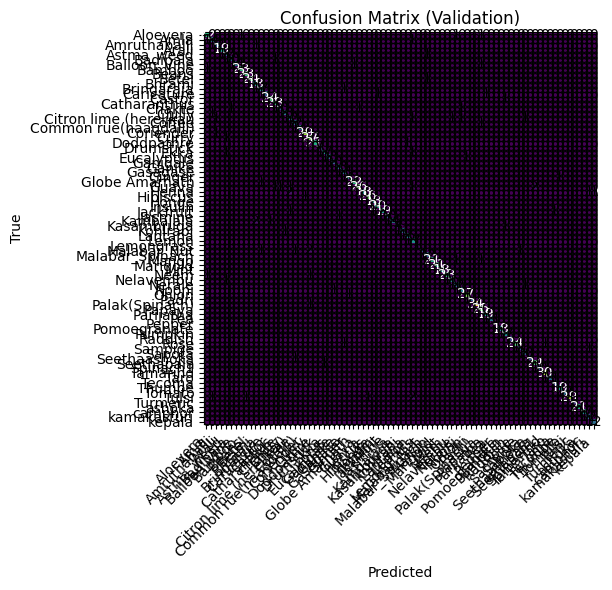

In [13]:
# Load best model weights if saved
if os.path.exists("best_model.pth"):
    model.load_state_dict(torch.load("best_model.pth"))
    print("Loaded best_model.pth")

val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, criterion)
print("Val accuracy:", val_acc)
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(cm, interpolation='nearest')
ax.set_xticks(np.arange(len(class_names))); ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right'); ax.set_yticklabels(class_names)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        ax.text(j, i, cm[i,j], ha="center", va="center", color="white" if cm[i,j] > cm.max()/2 else "black")
ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title('Confusion Matrix (Validation)')
plt.tight_layout()
os.makedirs('report_figs', exist_ok=True)
plt.savefig('report_figs/fig1_confusion_matrix.png', dpi=200)
plt.show()

In [16]:
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm